# LSTM

_https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/_

### Setup

In [46]:
# import pandas
import pandas as pd

# import matplotlib
%matplotlib inline
import matplotlib

plt = matplotlib.pyplot
matplotlib.rcParams['figure.figsize'] = [15, 8]

# preprocessing
from sklearn.preprocessing import MinMaxScaler

# models
from keras.models import Sequential
from keras.layers import Dense, LSTM

# saving
import pickle

### Load Observations

                           airtemp  cloudcover  precip  107337_00065  \
2008-01-01 06:15:00+00:00     -7.0         2.0     0.0          4.88   
2008-01-01 06:30:00+00:00     -7.5         3.0     0.0          4.88   
2008-01-01 06:45:00+00:00     -8.0         3.0     0.0          4.88   
2008-01-01 07:00:00+00:00     -7.5         1.9     0.0          4.88   
2008-01-01 07:15:00+00:00     -7.0         1.8     0.0          4.87   

                           107338_00010  
2008-01-01 06:15:00+00:00           1.9  
2008-01-01 06:30:00+00:00           1.9  
2008-01-01 06:45:00+00:00           1.9  
2008-01-01 07:00:00+00:00           1.9  
2008-01-01 07:15:00+00:00           1.9  


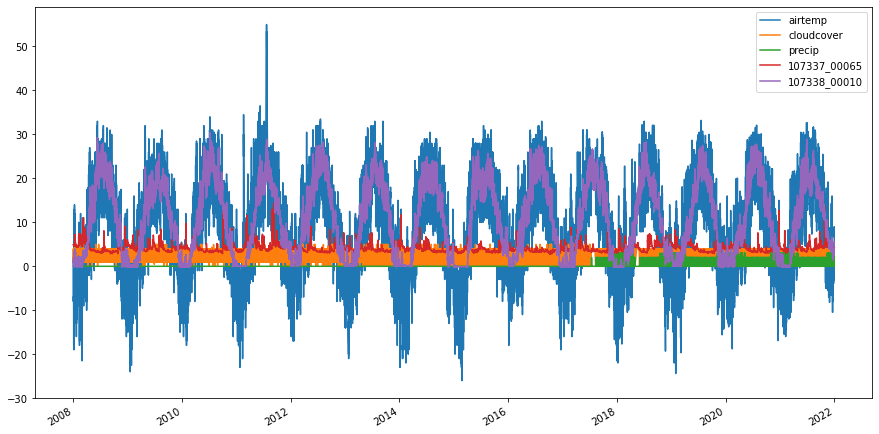

In [41]:
observations = pd.read_pickle('output/observations.pickle')

print(observations.head())
observations.plot()
plt.show()

### Prepare Dataframe for LSTM

In [53]:
values = observations.values

# ensure values are floats
values = values.astype('float')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
pickle.dump(scaler, open('output/scaler.pickle', 'wb'))

# ! revisit
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# reframe data
reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[5, 6, 7, 8]], axis=1, inplace=True)
print(reframed.head())


   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)   var5(t)
1   0.234568       0.40        0.0   0.183074   0.071661  0.071661
2   0.228395       0.60        0.0   0.183074   0.071661  0.071661
3   0.222222       0.60        0.0   0.183074   0.071661  0.071661
4   0.228395       0.38        0.0   0.183074   0.071661  0.071661
5   0.234568       0.36        0.0   0.182211   0.071661  0.071661


### Split Train/Test

In [43]:
values = reframed.values
train_portion = 0.85 # 85%
divider = int(len(values) * train_portion)

train = values[:divider, :]
test = values[divider:, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(414612, 1, 5) (414612,) (73167, 1, 5) (73167,)


### Create Model

Epoch 1/10
1440/1440 - 2s - loss: 0.0789 - val_loss: 0.0586 - 2s/epoch - 1ms/step
Epoch 2/10
1440/1440 - 1s - loss: 0.0232 - val_loss: 0.0492 - 995ms/epoch - 691us/step
Epoch 3/10
1440/1440 - 1s - loss: 0.0172 - val_loss: 0.0412 - 978ms/epoch - 680us/step
Epoch 4/10
1440/1440 - 1s - loss: 0.0119 - val_loss: 0.0255 - 984ms/epoch - 683us/step
Epoch 5/10
1440/1440 - 1s - loss: 0.0072 - val_loss: 0.0168 - 976ms/epoch - 678us/step
Epoch 6/10
1440/1440 - 1s - loss: 0.0052 - val_loss: 0.0116 - 1s/epoch - 721us/step
Epoch 7/10
1440/1440 - 1s - loss: 0.0041 - val_loss: 0.0041 - 1s/epoch - 721us/step
Epoch 8/10
1440/1440 - 1s - loss: 0.0035 - val_loss: 0.0054 - 1s/epoch - 708us/step
Epoch 9/10
1440/1440 - 1s - loss: 0.0032 - val_loss: 0.0059 - 981ms/epoch - 682us/step
Epoch 10/10
1440/1440 - 1s - loss: 0.0031 - val_loss: 0.0059 - 979ms/epoch - 680us/step
Epoch 1/10
1440/1440 - 2s - loss: 0.0671 - val_loss: 0.0563 - 2s/epoch - 1ms/step
Epoch 2/10
1440/1440 - 1s - loss: 0.0204 - val_loss: 0.0483 -

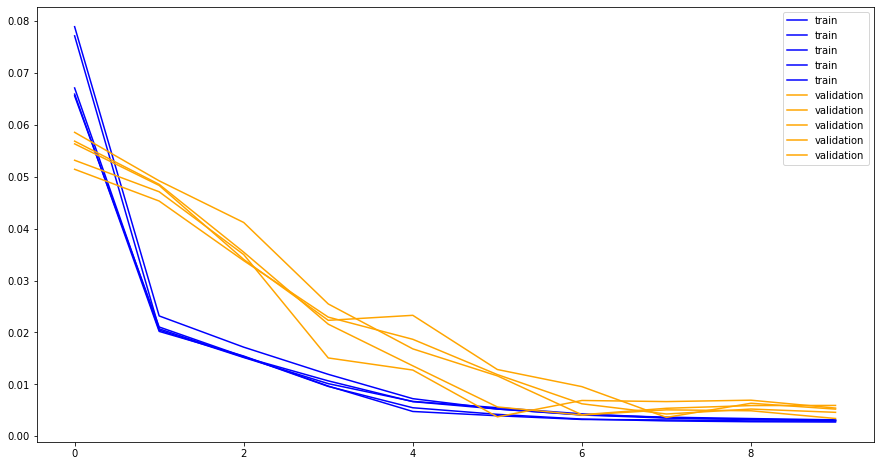

In [44]:
train = pd.DataFrame()
test = pd.DataFrame()
model = None
for i in range(5):
  # define model
  model = Sequential()
  model.add(LSTM(20, input_shape=(train_X.shape[1], train_X.shape[2])))
  model.add(Dense(1))
  model.compile(loss='mae', optimizer='adam')

  # fit
  history = model.fit(train_X, train_y, epochs=10, batch_size=288, validation_data=(test_X, test_y), verbose=2, shuffle=False)

  # record results
  train[str(i)] = history.history['loss']
  test[str(i)] = history.history['val_loss']

# save last model
model.save('output/model.h5')

plt.plot(train, color='blue', label='train')
plt.plot(test, color='orange', label='validation')
plt.legend()
plt.show()